## Checking that the H-matrices work!

In the future, we should probably move this to a test in `hmatrix.py`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy
import pickle
import numpy as np
import matplotlib.pyplot as plt
from celeri.hmatrix import build_hmatrix_from_mesh_tdes

with open('hmatrix_dev_data.pkl', 'rb') as f:
   estimation, operators, meshes, segment, station, command, index = pickle.load(f)

## Playing with H-matrices!

In [3]:
H = build_hmatrix_from_mesh_tdes(
    meshes[0],
    station,
    operators.meshes[0],
    1e-6,
    min_separation=1.25,
    min_pts_per_box=20,
)


(1841, 3) (1841,)


In [4]:
H.report_compression_ratio()

0.3058512026382072

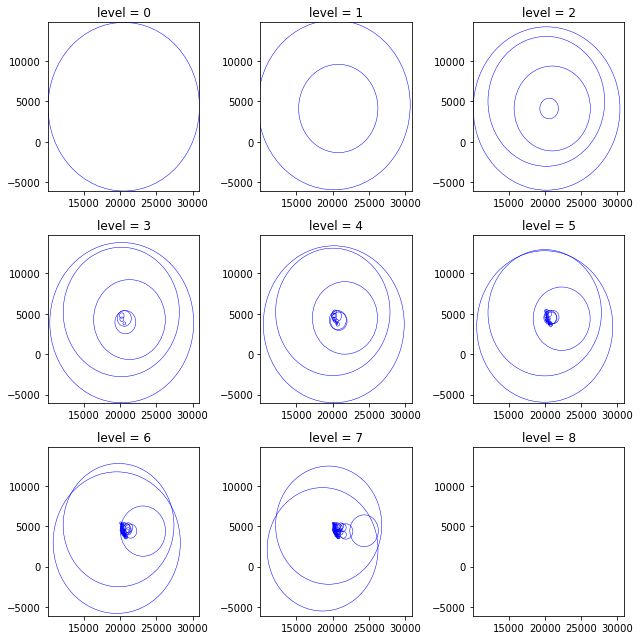

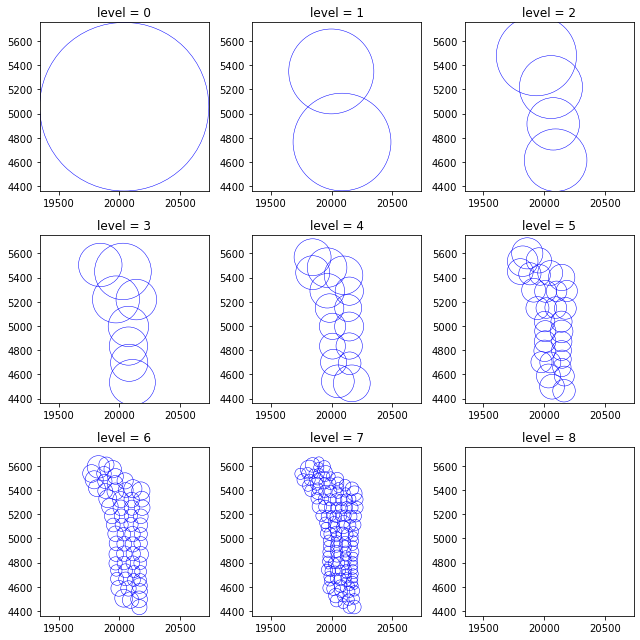

In [5]:
from celeri.hmatrix import plot_tree
plot_tree(H.obs_tree)
plot_tree(H.src_tree)

In [6]:
M = operators.meshes[0].tde_to_velocities
M = np.delete(M, np.arange(2, M.shape[0], 3), axis=0)
M = np.delete(M, np.arange(2, M.shape[1], 3), axis=1)

x = np.random.rand(M.shape[1])
y_true = M.dot(x)

In [7]:
%%time
y_h = H.dot(x)

CPU times: user 21.4 ms, sys: 16.4 ms, total: 37.8 ms
Wall time: 12 ms


/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_81639/3659102695.py:1: RuntimeWarning: divide by zero encountered in log10
  log10err = np.log10(np.abs(y_true - y_h))


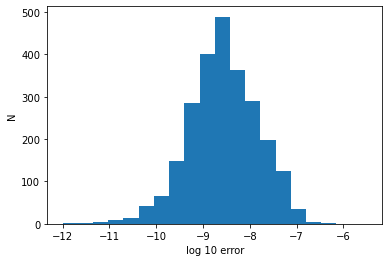

In [8]:
log10err = np.log10(np.abs(y_true - y_h))
plt.hist(log10err, bins=np.linspace(-12,-5.5,21))
plt.ylabel('N')
plt.xlabel('log 10 error')
plt.show()

In [10]:
y = np.random.rand(M.shape[0])
x_true = y @ M

In [13]:

x_h = H.transpose_dot(y)

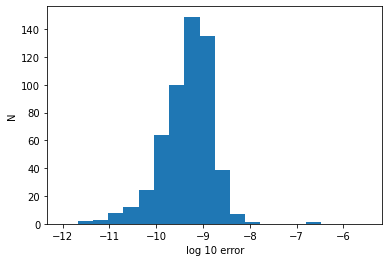

In [14]:
log10errx = np.log10(np.abs(x_true - x_h))
plt.hist(log10errx, bins=np.linspace(-12,-5.5,21))
plt.ylabel('N')
plt.xlabel('log 10 error')
plt.show()

## Playing with iterative solvers.

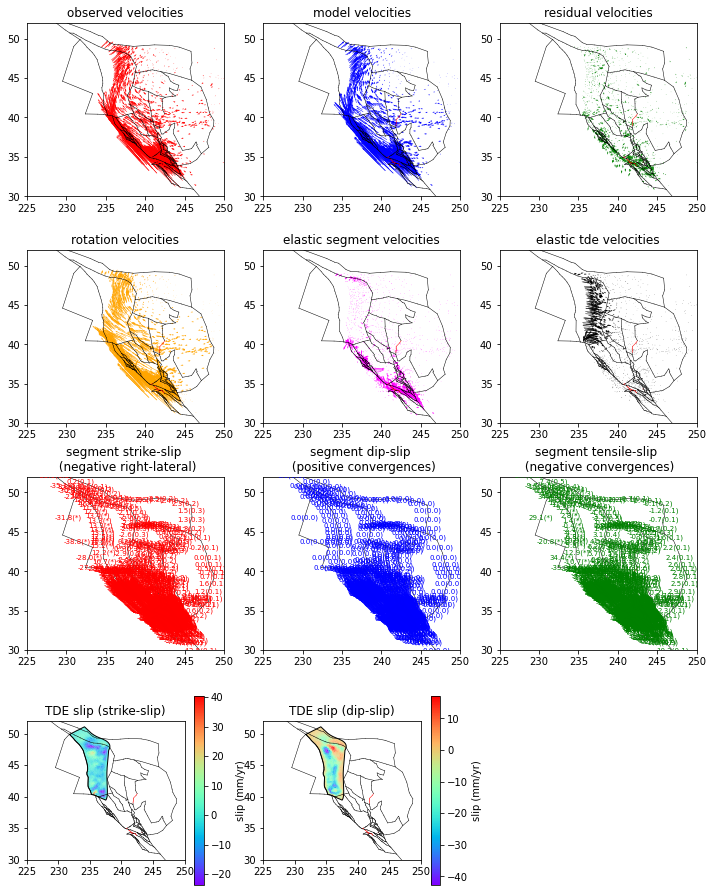

In [15]:
import celeri
# celeri.post_process_estimation(estimation, operators, station, index)
celeri.plot_estimation_summary(segment, station, meshes, estimation, lon_range=(225, 250), lat_range=(30, 52), quiver_scale=1e2)

**weighting**

In [16]:
import scipy.sparse
import scipy.sparse.linalg

W = estimation.weighting_vector
X = estimation.operator
y = estimation.data_vector
Xp = X * np.sqrt(W)[:, None]
yp = y * np.sqrt(W)

**preconditioning**

Scale each column of the data matrix to have a L2 norm of 1.

In [17]:
col_norms = np.linalg.norm(Xp, axis=0)
XpP = Xp / col_norms[None, :]

In [18]:
lsmr_dense = scipy.sparse.linalg.lsmr(XpP, yp, atol=1e-13, btol=1e-13)
# correct the solution for the col_norms preconditioning.
lsmr_dense_soln = lsmr_dense[0] / col_norms

In [19]:
print('exit code: ', lsmr_dense[1])
print('n_iterations: ', lsmr_dense[2])
print('norm(b - Ax): ', lsmr_dense[3])
print('norm(A^H (b - Ax)): ', lsmr_dense[4])
print('norm(A): ', lsmr_dense[5])
print('cond(A): ', lsmr_dense[6])
print('norm(x): ', lsmr_dense[7])

exit code:  2
n_iterations:  2588
norm(b - Ax):  168.87313381539073
norm(A^H (b - Ax)):  1.1082318199648072e-09
norm(A):  66.8268036244175
cond(A):  7.065301631891651
norm(x):  6444.6154751725435


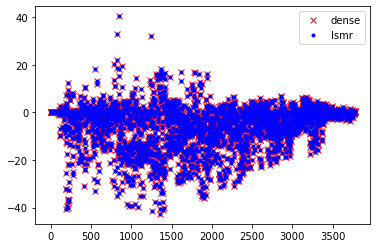

In [20]:
plt.figure()
plt.plot(estimation.state_vector, "rx", label="dense")
plt.plot(lsmr_dense_soln, "b.", label="lsmr")
plt.legend()
plt.show()

/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_81639/4169005962.py:5: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(relerr),bins=50)


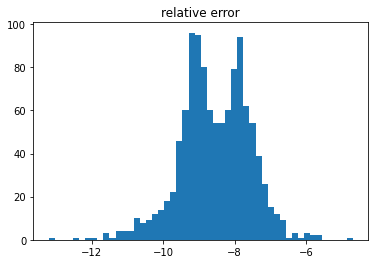

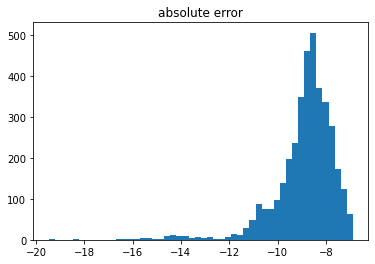

In [21]:
abserr = np.abs(lsmr_dense_soln - estimation.state_vector)
relerr = abserr / estimation.state_vector
plt.figure()
plt.title('relative error')
plt.hist(np.log10(relerr),bins=50)
plt.figure()
plt.title('absolute error')
plt.hist(np.log10(abserr),bins=50)
plt.show()

## Combining H-matrices and iterative solvers

**first check that the sparse component-ized matrix performs the same matvec as the dense version**

In [22]:
from scipy.sparse import csr_matrix
sparse_block_motion_okada_faults = csr_matrix(operators.rotation_to_velocities[index.station_row_keep_index, :] - operators.rotation_to_slip_rate_to_okada_to_velocities[index.station_row_keep_index, :])
sparse_block_motion_constraints = csr_matrix(operators.block_motion_constraints)
sparse_block_slip_rate_constraints = csr_matrix(operators.slip_rate_constraints)

tde_keep_row_index = celeri.get_keep_index_12(operators.meshes[0].tde_to_velocities.shape[0])
tde_keep_col_index = celeri.get_keep_index_12(operators.meshes[0].tde_to_velocities.shape[1])
smoothing_keep_index = celeri.get_keep_index_12(operators.meshes[0].smoothing_matrix.shape[0])
tde_matrix = operators.meshes[0].tde_to_velocities[tde_keep_row_index, :][:, tde_keep_col_index]
sparse_tde_smoothing = csr_matrix(operators.meshes[0].smoothing_matrix[smoothing_keep_index, :][:, smoothing_keep_index])
sparse_tde_slip_rate_constraints = csr_matrix(operators.meshes[0].tde_slip_rate_constraints)

In [23]:
def matvec(v):
    v_scaled = v / col_norms 

    out = np.zeros(X.shape[0])

    block_rotations = v_scaled[index.start_block_col : index.end_block_col]
    # okada
    out[
        index.start_station_row : index.end_station_row
    ] += sparse_block_motion_okada_faults.dot(block_rotations)

    # block motion constraints
    out[
        index.start_block_constraints_row : index.end_block_constraints_row
    ] += sparse_block_motion_constraints.dot(block_rotations)

    # slip rate constraints
    out[
        index.start_slip_rate_constraints_row : index.end_slip_rate_constraints_row
    ] += sparse_block_slip_rate_constraints.dot(block_rotations)

    tde_velocities = v_scaled[index.meshes[0].start_tde_col : index.meshes[0].end_tde_col]

    # Insert TDE to velocity matrix
    out[index.start_station_row : index.end_station_row] += H.dot(tde_velocities)

    # TDE smoothing
    out[
        index.meshes[0].start_tde_smoothing_row : index.meshes[0].end_tde_smoothing_row
    ] += sparse_tde_smoothing.dot(tde_velocities)

    # TDE slip rate constraints
    out[
        index.meshes[0].start_tde_constraint_row :
        index.meshes[0].end_tde_constraint_row
    ] += sparse_tde_slip_rate_constraints.dot(tde_velocities)

    # Weight!
    return out * np.sqrt(W)

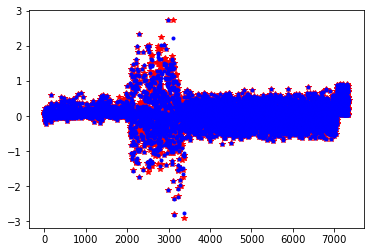

In [24]:
rand_vec = np.random.rand(X.shape[1])
y1 = XpP.dot(rand_vec)
y2 = matvec(rand_vec)
plt.plot(y1, 'r*', label='dense')
plt.plot(y2, 'b.', label='sparse')
plt.show()

In [29]:
def rmatvec(u):
    u_weighted = u * np.sqrt(W)
    out = np.zeros(X.shape[1])

    station_rows = u_weighted[index.start_station_row : index.end_station_row]
    block_constraints = u_weighted[
        index.start_block_constraints_row : index.end_block_constraints_row
    ]
    slip_rate_constraints = u_weighted[
        index.start_slip_rate_constraints_row : index.end_slip_rate_constraints_row
    ]
    tde_smoothing = u_weighted[
        index.meshes[0].start_tde_smoothing_row : index.meshes[0].end_tde_smoothing_row
    ]
    tde_slip_rate = u_weighted[
        index.meshes[0].start_tde_constraint_row :
        index.meshes[0].end_tde_constraint_row
    ]

    out[index.start_block_col : index.end_block_col] += station_rows @ sparse_block_motion_okada_faults
    out[index.start_block_col : index.end_block_col] += block_constraints @ sparse_block_motion_constraints
    out[index.start_block_col : index.end_block_col] += slip_rate_constraints @ sparse_block_slip_rate_constraints

    out[index.meshes[0].start_tde_col : index.meshes[0].end_tde_col] += H.transpose_dot(station_rows)
    out[index.meshes[0].start_tde_col : index.meshes[0].end_tde_col] += tde_smoothing @ sparse_tde_smoothing
    out[index.meshes[0].start_tde_col : index.meshes[0].end_tde_col] += tde_slip_rate @ sparse_tde_slip_rate_constraints

    # Weight!
    return out / col_norms

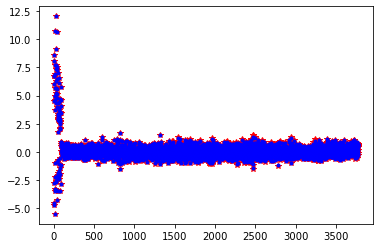

In [30]:
rand_vec = np.random.rand(X.shape[0])
y1 = rand_vec.dot(XpP)
y2 = rmatvec(rand_vec)
plt.plot(y1, 'r*', label='dense')
plt.plot(y2, 'b.', label='sparse')
plt.show()

## Solve with H-matrix/sparse!

In [31]:
op = scipy.sparse.linalg.LinearOperator(X.shape, matvec=matvec, rmatvec=rmatvec)

In [32]:
lsmr_sparse = scipy.sparse.linalg.lsmr(op, yp, atol=1e-13, btol=1e-13)
# correct the solution for the col_norms preconditioning.
lsmr_sparse_soln = lsmr_dense[0] / col_norms

In [33]:
print('exit code: ', lsmr_sparse[1])
print('n_iterations: ', lsmr_sparse[2])
print('norm(b - Ax): ', lsmr_sparse[3])
print('norm(A^H (b - Ax)): ', lsmr_sparse[4])
print('norm(A): ', lsmr_sparse[5])
print('cond(A): ', lsmr_sparse[6])
print('norm(x): ', lsmr_sparse[7])

exit code:  2
n_iterations:  2558
norm(b - Ax):  169.20864692183656
norm(A^H (b - Ax)):  1.0752683212497794e-09
norm(A):  66.18052270692985
cond(A):  5.954376329037577
norm(x):  6358.547889842487


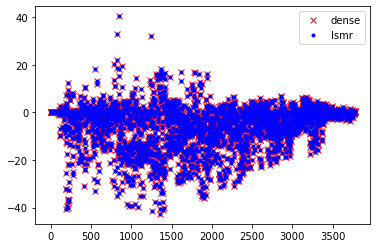

In [34]:
plt.figure()
plt.plot(estimation.state_vector, "rx", label="dense")
plt.plot(lsmr_sparse_soln, "b.", label="lsmr")
plt.legend()
plt.show()

/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_81639/2263015544.py:5: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(relerr),bins=50)


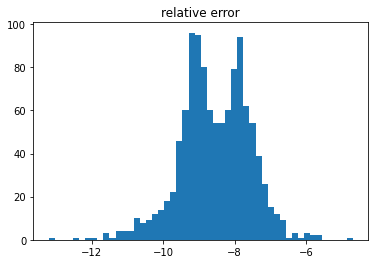

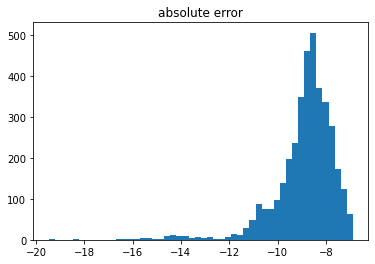

In [35]:
abserr = np.abs(lsmr_sparse_soln - estimation.state_vector)
relerr = abserr / estimation.state_vector
plt.figure()
plt.title('relative error')
plt.hist(np.log10(relerr),bins=50)
plt.figure()
plt.title('absolute error')
plt.hist(np.log10(abserr),bins=50)
plt.show()

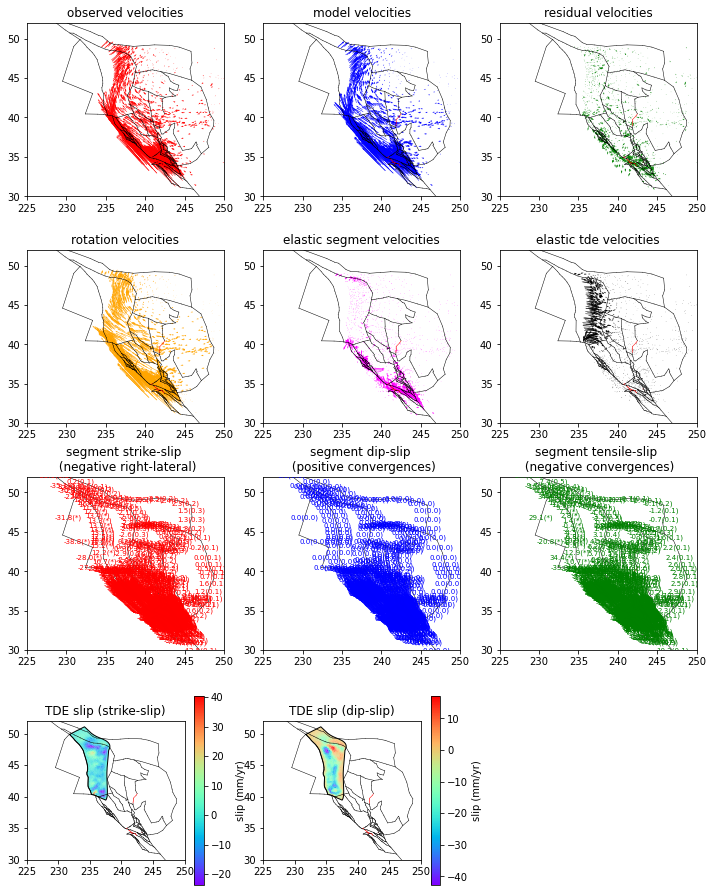

In [36]:
orig_state_vector = estimation.state_vector.copy()
estimation.state_vector = lsmr_sparse_soln
celeri.plot_estimation_summary(segment, station, meshes, estimation, lon_range=(225, 250), lat_range=(30, 52), quiver_scale=1e2)
estimation.state_vector = orig_state_vector